<a href="https://colab.research.google.com/github/ramanaruban29/AWS-and-PHP-site/blob/main/Copy_of_New_execution1_New_Dataset_Model_depth_increased_with_Adam_Optimizer_final_method_of_Modified_ResNet_152_latest_new_method_RMFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import numpy as np
import pickle
import os
from PIL import Image
import random
import time
import torchvision
import re
from torch import Tensor
from typing import Type
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/RMFDRealDataset/Training"

with open("/content/drive/MyDrive/RMFDRealDataset/Newlabels.txt") as label_file:
    labels = label_file.read().split()
    label_mapping = dict(zip(labels, list(range(len(labels)))))
    print(label_mapping)

{'aidai': 0, 'anhu': 1, 'axin': 2, 'baibaihe': 3, 'baijingting': 4, 'baike': 5, 'baobeier': 6, 'baojianfeng': 7, 'benxi': 8, 'caiguoqing': 9, 'caihancen': 10, 'caiyilin': 11, 'caizhuoyan': 12, 'caobingkun': 13, 'caoying': 14, 'caoyunjin': 15, 'cengyongti': 16, 'changshilei': 17, 'changyuan': 18, 'chenbailin': 19, 'chenderong': 20, 'chendouling': 21, 'chenfarong': 22, 'chenglong': 23, 'chenguanxi': 24, 'chenhaomin': 25, 'chenhe': 26, 'chenhuilin': 27, 'chenhuixian': 28, 'chenjiaqi': 29, 'chenkun': 30, 'chenlong': 31, 'chenqiaoen': 32, 'chenshu': 33, 'chenweiting': 34, 'chenxiang': 35, 'chenxinyu': 36, 'chenxuedong': 37, 'chenyanxi': 38, 'chenyao': 39, 'chenyixun': 40, 'chenyi': 41, 'chenyufan': 42, 'chenzhipeng': 43, 'cuishengxian': 44, 'cuixiuying': 45, 'daipeini': 46, 'dazhangwei': 47, 'dengchao': 48, 'denglun': 49, 'dengziqi': 50, 'dilireba': 51, 'dingding': 52, 'dingning': 53, 'ditianlin': 54, 'dongchengpeng': 55, 'dongjie': 56, 'dongxuan': 57, 'dongyongpei': 58, 'duhaitao': 59, 'du

In [ ]:
import numpy as np
import cv2

from pathlib import Path

imageFilesDir = Path(r'/content/drive/MyDrive/RMFDRealDataset/Training')
files = list(imageFilesDir.rglob('*.jpg'))

len(files)

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(files)

for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.

    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

print(mean)


KeyboardInterrupt: ignored

In [ ]:
for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += ((im[:,:,j] - mean[j])**2).sum()/(im.shape[0]*im.shape[1])

std = np.sqrt(stdTemp/numSamples)

print(std)

In [ ]:
import numpy as np
import cv2

from pathlib import Path

imageFilesDir = Path(r'/content/drive/MyDrive/RMFDRealDataset/Training')
files = list(imageFilesDir.rglob('*.jpg'))

len(files)

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(files)

for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.

    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

print(mean)

KeyboardInterrupt: ignored

In [ ]:
from PIL import Image

import torch
import torchvision.transforms as transforms

def preprocess(image):
   # Resize the image to 224x224 pixels
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        # Randomly flip the image horizontally with a probability of 0.5
        transforms.RandomHorizontalFlip(p=0.5),
        # Apply random color jitter to the image
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.60859828, 0.48116896, 0.42827668], std=[0.27922143, 0.24897663,0.23708099]),

    ])
    image = transform(image)

    # Add an extra dimension to the tensor to create a batch of size 1
    #image = image.unsqueeze(1)

    return image

In [ ]:
from PIL import Image

import torch
import torchvision.transforms as transforms

def preprocess1(image):
   # Resize the image to 224x224 pixels
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.60859828, 0.48116896, 0.42827668], std=[0.27922143, 0.24897663,0.23708099])
    ])
    image = transform(image)

    # Add an extra dimension to the tensor to create a batch of size 1
    #image = image.unsqueeze(1)

    return image

In [ ]:
from PIL import Image

class RMFRDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, data_size = 0, transforms = None):
        files = os.listdir(data_dir)
        files = [os.path.join(data_dir,x) for x in files]


        if data_size < 0 or data_size > len(files):
            assert("Data size should be between 0 to number of files in the dataset")

        if data_size == 0:
            data_size = len(files)

        self.data_size = data_size
        self.files = random.sample(files, self.data_size)
        self.transforms = transforms

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        image_address = self.files[idx]
        image = Image.open(image_address)
        image = preprocess(image)

        label_name = image_address.split("_")[2]
        #print(label_name)
        label = label_mapping[label_name]


        if self.transforms:
            image = self.transforms(image)

        return image, label


In [ ]:
from PIL import Image

class RMFRDataset1(torch.utils.data.Dataset):

    def __init__(self, data_dir, data_size = 0, transforms = None):
        files = os.listdir(data_dir)
        files = [os.path.join(data_dir,x) for x in files]


        if data_size < 0 or data_size > len(files):
            assert("Data size should be between 0 to number of files in the dataset")

        if data_size == 0:
            data_size = len(files)

        self.data_size = data_size
        self.files = random.sample(files, self.data_size)
        self.transforms = transforms

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        image_address = self.files[idx]
        image = Image.open(image_address)
        image = preprocess1(image)

        label_name = image_address.split("_")[2]

        label = label_mapping[label_name]


        if self.transforms:
            image = self.transforms(image)

        return image, label


In [ ]:
trainset = RMFRDataset(data_dir = "/content/drive/MyDrive/RMFDRealDataset/Training",transforms=None)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

validset = RMFRDataset(data_dir = "/content/drive/MyDrive/RMFDRealDataset2/Validation",transforms=None)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True, num_workers=2)

#testset = RMFRDataset1(data_dir = "/content/drive/MyDrive/Dataset_Original/test",transforms=None)
#testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
# Save the trained model
torch.save(classifier.state_dict(), "my_model.pth")

In [ ]:
from google.colab import files

# Download the saved model file
files.download("my_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models

# Load a pre-trained ResNet152 model and freeze the last layer
clf = models.resnet152(pretrained=True)

for param in clf.fc.parameters():
     param.requires_grad = True

num_features = clf.fc.in_features
clf.fc = nn.Identity()
# Replace the last fully connected layer with a new one for 531 classes
clf.fc = nn.Linear(num_features, 531)

# Set requires_grad to True for the last layer's weight and bias
clf.fc.weight.requires_grad_()
clf.fc.bias.requires_grad_()

# Create a new classifier by removing the original last layer
classifier = nn.Sequential(*list(clf.children())[:-1])

# Move the model and loss function to the GPU if available
classifier = classifier.cuda()
criterion = nn.CrossEntropyLoss().cuda()

# Define the optimizer and learning rate scheduler
optimizer = optim.Adam(classifier.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
print(classifier)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
#Arcface loss
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models

# Load a pre-trained ResNet152 model and freeze the last layer
classifier = models.resnet152(pretrained=True)

# Keep the first part of the model for feature extraction
features = nn.Sequential(*list(classifier .children())[:-1])

# Set the feature extractor and the classifier layer
num_features = classifier.fc.in_features
classifier.fc = ArcMarginProduct(in_features=num_features, out_features=525)

# Move the model and loss function to the GPU if available
classifier = classifier.cuda()

# Define the optimizer and learning rate scheduler
optimizer = optim.Adam(classifier.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)

print(clf)


In [ ]:
for epoch in range(100):
    classifier.train()
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        # No need to change label dimensions
        # labels = torch.unsqueeze(labels, 1)
        # labels = torch.unsqueeze(labels, 1)

        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{10}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")
    scheduler.step()

    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            # No need to change label dimensions
            # labels = torch.unsqueeze(labels, 1)
            # labels = torch.unsqueeze(labels, 1)

            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples
    # Print the training and validation losses and accuracy
    print(f"Epoch {epoch+1}/{100}: train_loss = {loss.item():.4f}, test_loss = {test_loss:.4f}, test_acc = {100*test_acc:.4f}")

Epoch 1/10, Batch 0/129, Loss 3.9426
Epoch 1/10, Batch 10/129, Loss 3.6026
Epoch 1/10, Batch 20/129, Loss 3.5698
Epoch 1/10, Batch 30/129, Loss 3.3756
Epoch 1/10, Batch 40/129, Loss 3.2506
Epoch 1/10, Batch 50/129, Loss 3.8449
Epoch 1/10, Batch 60/129, Loss 3.7189
Epoch 1/10, Batch 70/129, Loss 3.7210
Epoch 1/10, Batch 80/129, Loss 3.6716
Epoch 1/10, Batch 90/129, Loss 3.8572
Epoch 1/10, Batch 100/129, Loss 3.7422
Epoch 1/10, Batch 110/129, Loss 3.5723
Epoch 1/10, Batch 120/129, Loss 3.6739
Epoch 1/100: train_loss = 4.3999, test_loss = 4.5354, test_acc = 4.2870
Epoch 2/10, Batch 0/129, Loss 3.5887
Epoch 2/10, Batch 10/129, Loss 3.7390
Epoch 2/10, Batch 20/129, Loss 3.4576
Epoch 2/10, Batch 30/129, Loss 3.8562
Epoch 2/10, Batch 40/129, Loss 3.7265
Epoch 2/10, Batch 50/129, Loss 3.6625
Epoch 2/10, Batch 60/129, Loss 3.7021
Epoch 2/10, Batch 70/129, Loss 3.7325
Epoch 2/10, Batch 80/129, Loss 3.5092
Epoch 2/10, Batch 90/129, Loss 3.6375
Epoch 2/10, Batch 100/129, Loss 3.4118
Epoch 2/10, Ba

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(100):
    classifier.train()
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        # No need to change label dimensions
        # labels = torch.unsqueeze(labels, 1)
        # labels = torch.unsqueeze(labels, 1)

        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{10}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")
    scheduler.step()

    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            # No need to change label dimensions
            # labels = torch.unsqueeze(labels, 1)
            # labels = torch.unsqueeze(labels, 1)

            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples
    # Print the training and validation losses and accuracy
    print(f"Epoch {epoch+1}/{100}: train_loss = {loss.item():.4f}, test_loss = {test_loss:.4f}, test_acc = {100*test_acc:.4f}")

Epoch 1/10, Batch 0/129, Loss 7.6290
Epoch 1/10, Batch 10/129, Loss 7.4163
Epoch 1/10, Batch 20/129, Loss 5.2330
Epoch 1/10, Batch 30/129, Loss 5.1582
Epoch 1/10, Batch 40/129, Loss 4.5704
Epoch 1/10, Batch 50/129, Loss 4.2471
Epoch 1/10, Batch 60/129, Loss 3.9268
Epoch 1/10, Batch 70/129, Loss 3.6325
Epoch 1/10, Batch 80/129, Loss 4.3302
Epoch 1/10, Batch 90/129, Loss 3.1468
Epoch 1/10, Batch 100/129, Loss 3.3603
Epoch 1/10, Batch 110/129, Loss 3.4526
Epoch 1/10, Batch 120/129, Loss 3.1364
Epoch 1/100: train_loss = 4.3268, test_loss = 4.5098, test_acc = 8.2240
Epoch 2/10, Batch 0/129, Loss 3.2698
Epoch 2/10, Batch 10/129, Loss 2.8603
Epoch 2/10, Batch 20/129, Loss 2.6405
Epoch 2/10, Batch 30/129, Loss 3.1820
Epoch 2/10, Batch 40/129, Loss 3.3571
Epoch 2/10, Batch 50/129, Loss 2.5927
Epoch 2/10, Batch 60/129, Loss 2.4942
Epoch 2/10, Batch 70/129, Loss 3.0608
Epoch 2/10, Batch 80/129, Loss 2.6032
Epoch 2/10, Batch 90/129, Loss 2.6040
Epoch 2/10, Batch 100/129, Loss 2.4930
Epoch 2/10, Ba

Epoch 1/100, Batch 0/65, Loss 7.6702
Epoch 1/100, Batch 10/65, Loss 7.0109
Epoch 1/100, Batch 20/65, Loss 6.4962
Epoch 1/100, Batch 30/65, Loss 5.7102
Epoch 1/100, Batch 40/65, Loss 5.7030
Epoch 1/100, Batch 50/65, Loss 5.1761
Epoch 1/100, Batch 60/65, Loss 5.1937
Epoch 1/100: train_loss=6.0578, test_loss=12.2683, test_acc=2.0997%
Epoch 2/100, Batch 0/65, Loss 5.0312
Epoch 2/100, Batch 10/65, Loss 4.8224
Epoch 2/100, Batch 20/65, Loss 4.5162
Epoch 2/100, Batch 30/65, Loss 3.9285
Epoch 2/100, Batch 40/65, Loss 4.3675
Epoch 2/100, Batch 50/65, Loss 4.2884
Epoch 2/100, Batch 60/65, Loss 3.8593
Epoch 2/100: train_loss=4.3525, test_loss=5.8587, test_acc=2.0997%
Epoch 3/100, Batch 0/65, Loss 3.9638
Epoch 3/100, Batch 10/65, Loss 3.8834
Epoch 3/100, Batch 20/65, Loss 4.1162
Epoch 3/100, Batch 30/65, Loss 3.8348
Epoch 3/100, Batch 40/65, Loss 3.9127
Epoch 3/100, Batch 50/65, Loss 3.8349
Epoch 3/100, Batch 60/65, Loss 3.7635
Epoch 3/100: train_loss=3.8125, test_loss=4.9234, test_acc=4.4619%
Epo

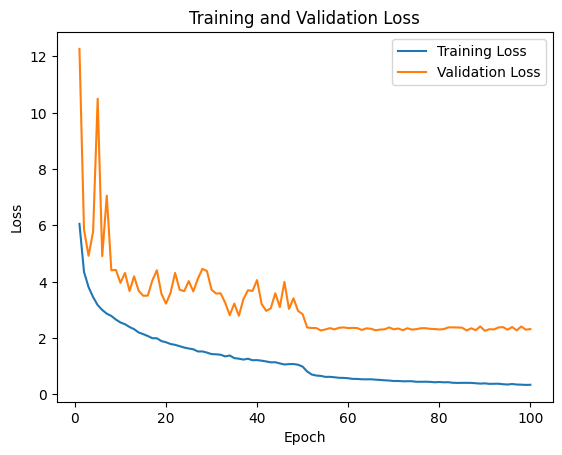

In [ ]:
import matplotlib.pyplot as plt

# Training loop
train_losses = []
test_losses = []

for epoch in range(100):
    # Set the model to training mode
    classifier.train()

    # Variables to keep track of losses
    train_loss = 0

    # Loop over the batches in the training dataset
    for i, (inputs, labels) in enumerate(trainloader):
        # Move the inputs and labels to the GPU if available
        inputs = inputs.cuda()
        labels = labels.cuda()

        labels = torch.unsqueeze(labels, 1)
        labels = torch.unsqueeze(labels, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{100}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")

    # Update the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = torch.unsqueeze(labels, 1)
            labels = torch.unsqueeze(labels, 1)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples

    # Print the training and validation losses and accuracy
    avg_train_loss = train_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{100}: train_loss={avg_train_loss:.4f}, test_loss={test_loss:.4f}, test_acc={100*test_acc:.4f}%")

    # Append the losses for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)

# Plotting the loss graph
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Training loop
train_losses = []
test_losses = []

for epoch in range(100):
    # Set the model to training mode
    classifier.train()

    # Variables to keep track of losses
    train_loss = 0

    # Loop over the batches in the training dataset
    for i, (inputs, labels) in enumerate(trainloader):
        # Move the inputs and labels to the GPU if available
        inputs = inputs.cuda()
        labels = labels.cuda()

        labels = torch.unsqueeze(labels, 1)
        labels = torch.unsqueeze(labels, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{100}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")

    # Update the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = torch.unsqueeze(labels, 1)
            labels = torch.unsqueeze(labels, 1)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples

    # Print the training and validation losses and accuracy
    avg_train_loss = train_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{100}: train_loss={avg_train_loss:.4f}, test_loss={test_loss:.4f}, test_acc={100*test_acc:.4f}%")

    # Append the losses for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)

# Plotting the loss graph
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Epoch 1/100, Batch 0/65, Loss 7.6788
Epoch 1/100, Batch 10/65, Loss 7.1865
Epoch 1/100, Batch 20/65, Loss 6.7876
Epoch 1/100, Batch 30/65, Loss 6.4996
Epoch 1/100, Batch 40/65, Loss 6.3008
Epoch 1/100, Batch 50/65, Loss 6.2380
Epoch 1/100, Batch 60/65, Loss 5.6094
Epoch 1/100: train_loss=6.5472, test_loss=6.2581, test_acc=4.5494%
Epoch 2/100, Batch 0/65, Loss 5.6404
Epoch 2/100, Batch 10/65, Loss 5.7501
Epoch 2/100, Batch 20/65, Loss 5.8811
Epoch 2/100, Batch 30/65, Loss 5.6011
Epoch 2/100, Batch 40/65, Loss 5.3115
Epoch 2/100, Batch 50/65, Loss 5.3324
Epoch 2/100, Batch 60/65, Loss 5.1004
Epoch 2/100: train_loss=5.4651, test_loss=6.3134, test_acc=6.1242%
Epoch 3/100, Batch 0/65, Loss 4.8596
Epoch 3/100, Batch 10/65, Loss 4.9956
Epoch 3/100, Batch 20/65, Loss 5.0234
Epoch 3/100, Batch 30/65, Loss 4.9054
Epoch 3/100, Batch 40/65, Loss 4.5135
Epoch 3/100, Batch 50/65, Loss 4.4770
Epoch 3/100, Batch 60/65, Loss 4.4157
Epoch 3/100: train_loss=4.7930, test_loss=5.3223, test_acc=10.3237%
Epo

Epoch 1/100, Batch 0/65, Loss 7.6496
Epoch 1/100, Batch 10/65, Loss 7.4211
Epoch 1/100, Batch 20/65, Loss 7.1518
Epoch 1/100, Batch 30/65, Loss 6.7651
Epoch 1/100, Batch 40/65, Loss 6.6748
Epoch 1/100, Batch 50/65, Loss 6.2381
Epoch 1/100, Batch 60/65, Loss 5.5019
Epoch 1/100: train_loss=6.7953, test_loss=6.2702, test_acc=23.1846%
Epoch 2/100, Batch 0/65, Loss 5.4326
Epoch 2/100, Batch 10/65, Loss 5.4421
Epoch 2/100, Batch 20/65, Loss 5.3978
Epoch 2/100, Batch 30/65, Loss 4.5454
Epoch 2/100, Batch 40/65, Loss 4.3780
Epoch 2/100, Batch 50/65, Loss 4.6966
Epoch 2/100, Batch 60/65, Loss 4.0065
Epoch 2/100: train_loss=4.8101, test_loss=5.2506, test_acc=33.0709%
Epoch 3/100, Batch 0/65, Loss 3.7766
Epoch 3/100, Batch 10/65, Loss 3.5985
Epoch 3/100, Batch 20/65, Loss 3.5328
Epoch 3/100, Batch 30/65, Loss 3.7597
Epoch 3/100, Batch 40/65, Loss 3.2171
Epoch 3/100, Batch 50/65, Loss 3.4375
Epoch 3/100, Batch 60/65, Loss 3.4819
Epoch 3/100: train_loss=3.5557, test_loss=4.2836, test_acc=41.4698%
E

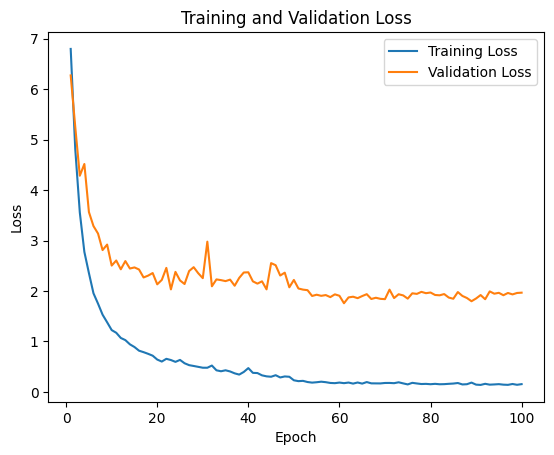

In [ ]:
import matplotlib.pyplot as plt

# Training loop
train_losses = []
test_losses = []

for epoch in range(100):
    # Set the model to training mode
    classifier.train()

    # Variables to keep track of losses
    train_loss = 0

    # Loop over the batches in the training dataset
    for i, (inputs, labels) in enumerate(trainloader):
        # Move the inputs and labels to the GPU if available
        inputs = inputs.cuda()
        labels = labels.cuda()

        labels = torch.unsqueeze(labels, 1)
        labels = torch.unsqueeze(labels, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{100}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")

    # Update the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = torch.unsqueeze(labels, 1)
            labels = torch.unsqueeze(labels, 1)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples

    # Print the training and validation losses and accuracy
    avg_train_loss = train_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{100}: train_loss={avg_train_loss:.4f}, test_loss={test_loss:.4f}, test_acc={100*test_acc:.4f}%")

    # Append the losses for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)

# Plotting the loss graph
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Epoch 1/100, Batch 0/65, Loss 5.2272
Epoch 1/100, Batch 10/65, Loss 5.0380
Epoch 1/100, Batch 20/65, Loss 4.7762
Epoch 1/100, Batch 30/65, Loss 4.6629
Epoch 1/100, Batch 40/65, Loss 4.1443
Epoch 1/100, Batch 50/65, Loss 4.1253
Epoch 1/100, Batch 60/65, Loss 4.6357
Epoch 1/100: train_loss=4.7998, test_loss=5.3868, test_acc=31.7887%
Epoch 2/100, Batch 0/65, Loss 3.7641
Epoch 2/100, Batch 10/65, Loss 3.4645
Epoch 2/100, Batch 20/65, Loss 3.7040
Epoch 2/100, Batch 30/65, Loss 4.1989
Epoch 2/100, Batch 40/65, Loss 3.3312
Epoch 2/100, Batch 50/65, Loss 3.1914
Epoch 2/100, Batch 60/65, Loss 3.3403
Epoch 2/100: train_loss=3.5413, test_loss=4.7013, test_acc=37.5811%
Epoch 3/100, Batch 0/65, Loss 2.6887
Epoch 3/100, Batch 10/65, Loss 3.2299
Epoch 3/100, Batch 20/65, Loss 2.5890
Epoch 3/100, Batch 30/65, Loss 2.7225
Epoch 3/100, Batch 40/65, Loss 2.6619
Epoch 3/100, Batch 50/65, Loss 2.7096
Epoch 3/100, Batch 60/65, Loss 2.3685
Epoch 3/100: train_loss=2.8439, test_loss=4.0445, test_acc=44.9954%
E

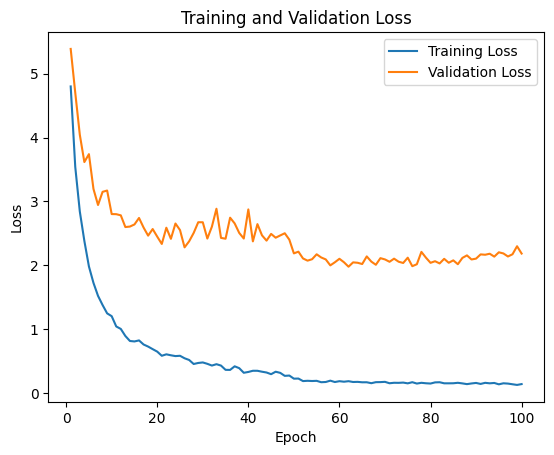

In [ ]:
import matplotlib.pyplot as plt

# Training loop
train_losses = []
test_losses = []

for epoch in range(100):
    # Set the model to training mode
    classifier.train()

    # Variables to keep track of losses
    train_loss = 0

    # Loop over the batches in the training dataset
    for i, (inputs, labels) in enumerate(trainloader):
        # Move the inputs and labels to the GPU if available
        inputs = inputs.cuda()
        labels = labels.cuda()

        labels = torch.unsqueeze(labels, 1)
        labels = torch.unsqueeze(labels, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{100}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")

    # Update the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in validloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = torch.unsqueeze(labels, 1)
            labels = torch.unsqueeze(labels, 1)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples

    # Print the training and validation losses and accuracy
    avg_train_loss = train_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{100}: train_loss={avg_train_loss:.4f}, test_loss={test_loss:.4f}, test_acc={100*test_acc:.4f}%")

    # Append the losses for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)

# Plotting the loss graph
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Training loop
train_losses = []
test_losses = []

for epoch in range(100):
    # Set the model to training mode
    classifier.train()

    # Variables to keep track of losses
    train_loss = 0

    # Loop over the batches in the training dataset
    for i, (inputs, labels) in enumerate(trainloader):
        # Move the inputs and labels to the GPU if available
        inputs = inputs.cuda()
        labels = labels.cuda()

        labels = torch.unsqueeze(labels, 1)
        labels = torch.unsqueeze(labels, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{100}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")

    # Update the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in validloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = torch.unsqueeze(labels, 1)
            labels = torch.unsqueeze(labels, 1)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples

    # Print the training and validation losses and accuracy
    avg_train_loss = train_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{100}: train_loss={avg_train_loss:.4f}, test_loss={test_loss:.4f}, test_acc={100*test_acc:.4f}%")

    # Append the losses for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)

# Plotting the loss graph
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Epoch 1/100, Batch 0/1286, Loss 7.6998
Epoch 1/100, Batch 10/1286, Loss 7.6685
Epoch 1/100, Batch 20/1286, Loss 7.6713
Epoch 1/100, Batch 30/1286, Loss 7.6619
Epoch 1/100, Batch 40/1286, Loss 7.7584
Epoch 1/100, Batch 50/1286, Loss 7.6073
Epoch 1/100, Batch 60/1286, Loss 7.5048
Epoch 1/100, Batch 70/1286, Loss 7.4289
Epoch 1/100, Batch 80/1286, Loss 7.3810
Epoch 1/100, Batch 90/1286, Loss 7.4704
Epoch 1/100, Batch 100/1286, Loss 7.4168
Epoch 1/100, Batch 110/1286, Loss 7.4391
Epoch 1/100, Batch 120/1286, Loss 7.2892
Epoch 1/100, Batch 130/1286, Loss 7.3685
Epoch 1/100, Batch 140/1286, Loss 7.3953
Epoch 1/100, Batch 150/1286, Loss 7.1830
Epoch 1/100, Batch 160/1286, Loss 7.2229


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

#New dataset
# Training loop
train_losses = []
test_losses = []

for epoch in range(100):
    # Set the model to training mode
    classifier.train()

    # Variables to keep track of losses
    train_loss = 0

    # Loop over the batches in the training dataset
    for i, (inputs, labels) in enumerate(trainloader):
        # Move the inputs and labels to the GPU if available
        inputs = inputs.cuda()
        labels = labels.cuda()

        labels = torch.unsqueeze(labels, 1)
        labels = torch.unsqueeze(labels, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{100}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")

    # Update the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in validloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = torch.unsqueeze(labels, 1)
            labels = torch.unsqueeze(labels, 1)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples

    # Print the training and validation losses and accuracy
    avg_train_loss = train_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{100}: train_loss={avg_train_loss:.4f}, test_loss={test_loss:.4f}, test_acc={100*test_acc:.4f}%")

    # Append the losses for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)

# Plotting the loss graph
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Epoch 1/100, Batch 0/195, Loss 5.9014
Epoch 1/100, Batch 10/195, Loss 5.8146
Epoch 1/100, Batch 20/195, Loss 6.0445
Epoch 1/100, Batch 30/195, Loss 5.8143
Epoch 1/100, Batch 40/195, Loss 5.4868
Epoch 1/100, Batch 50/195, Loss 5.7298
Epoch 1/100, Batch 60/195, Loss 5.8457
Epoch 1/100, Batch 70/195, Loss 5.7976
Epoch 1/100, Batch 80/195, Loss 5.4682
Epoch 1/100, Batch 90/195, Loss 5.6812
Epoch 1/100, Batch 100/195, Loss 5.7784
Epoch 1/100, Batch 110/195, Loss 5.3180
Epoch 1/100, Batch 120/195, Loss 5.5466
Epoch 1/100, Batch 130/195, Loss 5.6258
Epoch 1/100, Batch 140/195, Loss 5.5958
Epoch 1/100, Batch 150/195, Loss 5.3829
Epoch 1/100, Batch 160/195, Loss 5.4374
Epoch 1/100, Batch 170/195, Loss 5.4274
Epoch 1/100, Batch 180/195, Loss 5.2996
Epoch 1/100, Batch 190/195, Loss 5.2360
Epoch 1/100: train_loss=5.6191, test_loss=5.3919, test_acc=9.9501%
Epoch 2/100, Batch 0/195, Loss 5.0738
Epoch 2/100, Batch 10/195, Loss 5.0664
Epoch 2/100, Batch 20/195, Loss 4.9257
Epoch 2/100, Batch 30/195, L

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f973ccc3880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f973ccc3880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 3/100, Batch 90/195, Loss 4.1711
Epoch 3/100, Batch 100/195, Loss 4.1654
Epoch 3/100, Batch 110/195, Loss 4.1934
Epoch 3/100, Batch 120/195, Loss 4.0847
Epoch 3/100, Batch 130/195, Loss 4.2232
Epoch 3/100, Batch 140/195, Loss 4.5878
Epoch 3/100, Batch 150/195, Loss 4.1837
Epoch 3/100, Batch 160/195, Loss 4.7341
Epoch 3/100, Batch 170/195, Loss 4.0900
Epoch 3/100, Batch 180/195, Loss 4.5145
Epoch 3/100, Batch 190/195, Loss 4.2254
Epoch 3/100: train_loss=4.2963, test_loss=4.4568, test_acc=21.1295%
Epoch 4/100, Batch 0/195, Loss 3.8712
Epoch 4/100, Batch 10/195, Loss 3.6029
Epoch 4/100, Batch 20/195, Loss 4.0188
Epoch 4/100, Batch 30/195, Loss 4.0856
Epoch 4/100, Batch 40/195, Loss 3.5341
Epoch 4/100, Batch 50/195, Loss 3.9794
Epoch 4/100, Batch 60/195, Loss 3.7158
Epoch 4/100, Batch 70/195, Loss 3.8652
Epoch 4/100, Batch 80/195, Loss 3.9024
Epoch 4/100, Batch 90/195, Loss 3.7770
Epoch 4/100, Batch 100/195, Loss 3.6042
Epoch 4/100, Batch 110/195, Loss 4.0281
Epoch 4/100, Batch 120/1

In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!unzip Training.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/1_0_zhanghanyu_0163.jpg  
  inflating: Training/1_0_zhanghanyu_0165.jpg  
  inflating: Training/1_0_zhanghanyu_0168.jpg  
  inflating: Training/1_0_zhanghanyu_0169.jpg  
  inflating: Training/1_0_zhanghanyu_0173.jpg  
  inflating: Training/1_0_zhanghanyu_0174.jpg  
  inflating: Training/1_0_zhanghanyu_0175.jpg  
  inflating: Training/1_0_zhanghanyu_0177.jpg  
  inflating: Training/1_0_zhanghanyu_0183.jpg  
  inflating: Training/1_0_zhanghanyu_0186.jpg  
  inflating: Training/1_0_zhanghanyu_0187.jpg  
  inflating: Training/1_0_zhanghanyu_0188.jpg  
  inflating: Training/1_0_zhanghanyu_0189.jpg  
  inflating: Training/1_0_zhanghanyu_0190.jpg  
  inflating: Training/1_0_zhanghanyu_0192.jpg  
  inflating: Training/1_0_zhanghanyu_0193.jpg  
  inflating: Training/1_0_zhanghanyu_0197.jpg  
  inflating: Training/1_0_zhanghanyu_0198.jpg  
  inflating: Training/1_0_zhanghanyu_0199.jpg  
  inflating: Training/1_0_zhanghanyu_

In [ ]:
!unzip Validation.zip

Streaming output truncated to the last 5000 lines.
  inflating: Validation/1_0_zhanghan_0194.jpg  
  inflating: Validation/1_0_zhanghan_0196.jpg  
  inflating: Validation/1_0_zhanghan_0205.jpg  
  inflating: Validation/1_0_zhanghan_0206.jpg  
  inflating: Validation/1_0_zhanghan_0210.jpg  
  inflating: Validation/1_0_zhanghan_0214.jpg  
  inflating: Validation/1_0_zhanghe_0001.jpg  
  inflating: Validation/1_0_zhanghe_0003.jpg  
  inflating: Validation/1_0_zhanghe_0012.jpg  
  inflating: Validation/1_0_zhanghe_0013.jpg  
  inflating: Validation/1_0_zhanghe_0015.jpg  
  inflating: Validation/1_0_zhanghe_0016.jpg  
  inflating: Validation/1_0_zhanghe_0017.jpg  
  inflating: Validation/1_0_zhanghe_0020.jpg  
  inflating: Validation/1_0_zhanghe_0021.jpg  
  inflating: Validation/1_0_zhanghe_0022.jpg  
  inflating: Validation/1_0_zhanghe_0028.jpg  
  inflating: Validation/1_0_zhanghe_0030.jpg  
  inflating: Validation/1_0_zhanghe_0031.jpg  
  inflating: Validation/1_0_zhanghe_0033.jpg  
  i

In [ ]:
!unzip Training.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/1_0_zhanghanyu_0163.jpg  
  inflating: Training/1_0_zhanghanyu_0165.jpg  
  inflating: Training/1_0_zhanghanyu_0168.jpg  
  inflating: Training/1_0_zhanghanyu_0169.jpg  
  inflating: Training/1_0_zhanghanyu_0173.jpg  
  inflating: Training/1_0_zhanghanyu_0174.jpg  
  inflating: Training/1_0_zhanghanyu_0175.jpg  
  inflating: Training/1_0_zhanghanyu_0177.jpg  
  inflating: Training/1_0_zhanghanyu_0183.jpg  
  inflating: Training/1_0_zhanghanyu_0186.jpg  
  inflating: Training/1_0_zhanghanyu_0187.jpg  
  inflating: Training/1_0_zhanghanyu_0188.jpg  
  inflating: Training/1_0_zhanghanyu_0189.jpg  
  inflating: Training/1_0_zhanghanyu_0190.jpg  
  inflating: Training/1_0_zhanghanyu_0192.jpg  
  inflating: Training/1_0_zhanghanyu_0193.jpg  
  inflating: Training/1_0_zhanghanyu_0197.jpg  
  inflating: Training/1_0_zhanghanyu_0198.jpg  
  inflating: Training/1_0_zhanghanyu_0199.jpg  
  inflating: Training/1_0_zhanghanyu_

In [ ]:
import os

def count_files_in_folder(folder_path):
    file_count = 0
    for _, _, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# Specify the path of the folder you want to count the files in
folder_path = "/content/drive/MyDrive/Training"

# Call the function to get the number of files
num_files = count_files_in_folder(folder_path)

# Print the result
print("Number of files in the folder:", num_files)

Number of files in the folder: 46367


In [ ]:
import os

def count_files_in_folder(folder_path):
    file_count = 0
    for _, _, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# Specify the path of the folder you want to count the files in
folder_path = "/content/drive/MyDrive/Validation"

# Call the function to get the number of files
num_files = count_files_in_folder(folder_path)

# Print the result
print("Number of files in the folder:", num_files)

Number of files in the folder: 45910


In [ ]:
import re
import os

# specify the directory of your images
directory = '/content/drive/MyDrive/Validation'

# regular expression pattern
pattern = r'\d_\d_([\w]+)_\d'

# create a dictionary to store image names and their labels
labels = {}

for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"): # check the file extension
        match = re.search(pattern, filename)
        if match is not None:
            name = match.group(1) # this will be 'aidai'
            if name not in labels:
                labels[name] = len(labels) + 1

# specify the output text file
output_file = '/content/drive/MyDrive/Newlabels2.txt'

# write the labels to the output file
with open(output_file, 'w') as f:
    for name, label in labels.items():
        f.write(f'{name}: {label}\n')

print(f'Labels written to {output_file}')


Labels written to /content/drive/MyDrive/Newlabels2.txt


In [ ]:
import matplotlib.pyplot as plt

#New dataset
# Training loop
train_losses = []
test_losses = []

for epoch in range(100):
    # Set the model to training mode
    classifier.train()

    # Variables to keep track of losses
    train_loss = 0

    # Loop over the batches in the training dataset
    for i, (inputs, labels) in enumerate(trainloader):
        # Move the inputs and labels to the GPU if available
        inputs = inputs.cuda()
        labels = labels.cuda()

        labels = torch.unsqueeze(labels, 1)
        labels = torch.unsqueeze(labels, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{100}, Batch {i}/{len(trainloader)}, Loss {loss.item():.4f}")

    # Update the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    classifier.eval()
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for inputs, labels in validloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = torch.unsqueeze(labels, 1)
            labels = torch.unsqueeze(labels, 1)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_correct += torch.sum(predictions == labels)
            total_samples += inputs.size(0)
        test_loss = total_loss / total_samples
        test_acc = float(total_correct) / total_samples

    # Print the training and validation losses and accuracy
    avg_train_loss = train_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{100}: train_loss={avg_train_loss:.4f}, test_loss={test_loss:.4f}, test_acc={100*test_acc:.4f}%")

    # Append the losses for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)

# Plotting the loss graph
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


KeyError: ignored

In [ ]:
# Define your label files
label_file1 = '/content/drive/MyDrive/Newlabels.txt'
label_file2 = '/content/drive/MyDrive/Newlabels2.txt'

# Read labels from the first file
with open(label_file1, 'r') as file:
    labels1 = set(file.read().splitlines())

# Read labels from the second file
with open(label_file2, 'r') as file:
    labels2 = set(file.read().splitlines())

# Merge the two sets of labels
merged_labels = labels1.union(labels2)

# Write the merged labels to a new file
with open('merged_labels.txt', 'w') as file:
    for label in merged_labels:
        file.write(f'{label}\n')


In [ ]:
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define your directory and labels file
directory = '/content/drive/MyDrive/Validation'
labels_file = '/content/drive/MyDrive/Newlabels.txt'

# Read labels from the file
with open(labels_file, 'r') as file:
    labels = set(file.read().splitlines())

# List all files in the directory
files = os.listdir(directory)

# Loop over all files and remove files not found in labels
for file in files:
    # Remove .jpg extension for comparison
    if file.endswith('.jpg'):
        file_without_ext = file[:-4]  # Remove the last 4 characters (.jpg)
        if file_without_ext not in labels:
            print(f'Removing file: {file}')
            os.remove(os.path.join(directory, file))

Streaming output truncated to the last 5000 lines.
Removing file: 1_0_zhanghan_0184.jpg
Removing file: 1_0_zhanghan_0194.jpg
Removing file: 1_0_zhanghan_0196.jpg
Removing file: 1_0_zhanghan_0205.jpg
Removing file: 1_0_zhanghan_0206.jpg
Removing file: 1_0_zhanghan_0210.jpg
Removing file: 1_0_zhanghan_0214.jpg
Removing file: 1_0_zhanghe_0001.jpg
Removing file: 1_0_zhanghe_0003.jpg
Removing file: 1_0_zhanghe_0012.jpg
Removing file: 1_0_zhanghe_0013.jpg
Removing file: 1_0_zhanghe_0015.jpg
Removing file: 1_0_zhanghe_0016.jpg
Removing file: 1_0_zhanghe_0017.jpg
Removing file: 1_0_zhanghe_0020.jpg
Removing file: 1_0_zhanghe_0021.jpg
Removing file: 1_0_zhanghe_0022.jpg
Removing file: 1_0_zhanghe_0028.jpg
Removing file: 1_0_zhanghe_0030.jpg
Removing file: 1_0_zhanghe_0031.jpg
Removing file: 1_0_zhanghe_0033.jpg
Removing file: 1_0_zhanghe_0034.jpg
Removing file: 1_0_zhanghe_0035.jpg
Removing file: 1_0_zhanghe_0038.jpg
Removing file: 1_0_zhanghe_0039.jpg
Removing file: 1_0_zhanghe_0041.jpg
Removi

In [ ]:
import os

def count_files_in_folder(folder_path):
    file_count = 0
    for _, _, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# Specify the path of the folder you want to count the files in
folder_path = "/content/drive/MyDrive/Validation"

# Call the function to get the number of files
num_files = count_files_in_folder(folder_path)

# Print the result
print("Number of files in the folder:", num_files)

Number of files in the folder: 45907


In [ ]:
pwd

'/content'

In [ ]:
!unzip Validation.zip

Streaming output truncated to the last 5000 lines.
  inflating: Validation/1_0_zhanghan_0194.jpg  
  inflating: Validation/1_0_zhanghan_0196.jpg  
  inflating: Validation/1_0_zhanghan_0205.jpg  
  inflating: Validation/1_0_zhanghan_0206.jpg  
  inflating: Validation/1_0_zhanghan_0210.jpg  
  inflating: Validation/1_0_zhanghan_0214.jpg  
  inflating: Validation/1_0_zhanghe_0001.jpg  
  inflating: Validation/1_0_zhanghe_0003.jpg  
  inflating: Validation/1_0_zhanghe_0012.jpg  
  inflating: Validation/1_0_zhanghe_0013.jpg  
  inflating: Validation/1_0_zhanghe_0015.jpg  
  inflating: Validation/1_0_zhanghe_0016.jpg  
  inflating: Validation/1_0_zhanghe_0017.jpg  
  inflating: Validation/1_0_zhanghe_0020.jpg  
  inflating: Validation/1_0_zhanghe_0021.jpg  
  inflating: Validation/1_0_zhanghe_0022.jpg  
  inflating: Validation/1_0_zhanghe_0028.jpg  
  inflating: Validation/1_0_zhanghe_0030.jpg  
  inflating: Validation/1_0_zhanghe_0031.jpg  
  inflating: Validation/1_0_zhanghe_0033.jpg  
  i

In [ ]:
import os


# Define your directories and labels file
test_directory = '/content/drive/MyDrive/Validation'
train_labels_file = '/content/drive/MyDrive/Newlabels.txt'

# Read labels from the training file
with open(train_labels_file, 'r') as file:
    train_labels = set(file.read().splitlines())

# List all files in the test directory
test_files = os.listdir(test_directory)

# Loop over all test files and remove files not found in training labels
for file in test_files:
    if file not in train_labels:
        print(f'Removing file: {file}')
        os.remove(os.path.join(test_directory, file))

Streaming output truncated to the last 5000 lines.
Removing file: 1_0_zhanghan_0194.jpg
Removing file: 1_0_zhanghan_0196.jpg
Removing file: 1_0_zhanghan_0205.jpg
Removing file: 1_0_zhanghan_0206.jpg
Removing file: 1_0_zhanghan_0210.jpg
Removing file: 1_0_zhanghan_0214.jpg
Removing file: 1_0_zhanghe_0001.jpg
Removing file: 1_0_zhanghe_0003.jpg
Removing file: 1_0_zhanghe_0012.jpg
Removing file: 1_0_zhanghe_0013.jpg
Removing file: 1_0_zhanghe_0015.jpg
Removing file: 1_0_zhanghe_0016.jpg
Removing file: 1_0_zhanghe_0017.jpg
Removing file: 1_0_zhanghe_0020.jpg
Removing file: 1_0_zhanghe_0021.jpg
Removing file: 1_0_zhanghe_0022.jpg
Removing file: 1_0_zhanghe_0028.jpg
Removing file: 1_0_zhanghe_0030.jpg
Removing file: 1_0_zhanghe_0031.jpg
Removing file: 1_0_zhanghe_0033.jpg
Removing file: 1_0_zhanghe_0034.jpg
Removing file: 1_0_zhanghe_0035.jpg
Removing file: 1_0_zhanghe_0038.jpg
Removing file: 1_0_zhanghe_0039.jpg
Removing file: 1_0_zhanghe_0041.jpg
Removing file: 1_0_zhanghe_0049.jpg
Removin

In [ ]:
import os


# Define your directories and labels file
test_directory = '/content/drive/MyDrive/Training'
train_labels_file = '/content/drive/MyDrive/Newlabels.txt'

# Read labels from the training file and only consider the part before the colon
with open(train_labels_file, 'r') as file:
    train_labels = set([line.split(':')[0] for line in file.read().splitlines()])

# List all files in the test directory
test_files = os.listdir(test_directory)

# Loop over all test files and remove files if the third part (anystring) of the filename isn't in training labels
for file in test_files:
    # Extract third part of the filename (separated by underscores)
    name = file.split('_')[2]

    if name not in train_labels:
        print(f'Removing file: {file}')
        os.remove(os.path.join(test_directory, file))

In [ ]:
data_dir = "/content/drive/MyDrive/Newlabels.txt"
output_file = "/content/drive/MyDrive/Newlabels1.txt"

with open("/content/drive/MyDrive/Newlabels.txt") as label_file:
    names = []
    for line in label_file:
        name, _ = line.strip().split(':')
        names.append(name)

# Save the extracted names to the output file
with open(output_file, 'w') as outfile:
    outfile.write('\n'.join(names))

print("Extracted names have been saved to", output_file)

ValueError: ignored

In [ ]:
pwd


'/content'

In [ ]:
cd /content/drive/MyDrive/RMFDRealDataset

/content/drive/MyDrive/RMFDRealDataset


In [ ]:
!unzip Training.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/1_0_zhanghanyu_0163.jpg  
  inflating: Training/1_0_zhanghanyu_0165.jpg  
  inflating: Training/1_0_zhanghanyu_0168.jpg  
  inflating: Training/1_0_zhanghanyu_0169.jpg  
  inflating: Training/1_0_zhanghanyu_0173.jpg  
  inflating: Training/1_0_zhanghanyu_0174.jpg  
  inflating: Training/1_0_zhanghanyu_0175.jpg  
  inflating: Training/1_0_zhanghanyu_0177.jpg  
  inflating: Training/1_0_zhanghanyu_0183.jpg  
  inflating: Training/1_0_zhanghanyu_0186.jpg  
  inflating: Training/1_0_zhanghanyu_0187.jpg  
  inflating: Training/1_0_zhanghanyu_0188.jpg  
  inflating: Training/1_0_zhanghanyu_0189.jpg  
  inflating: Training/1_0_zhanghanyu_0190.jpg  
  inflating: Training/1_0_zhanghanyu_0192.jpg  
  inflating: Training/1_0_zhanghanyu_0193.jpg  
  inflating: Training/1_0_zhanghanyu_0197.jpg  
  inflating: Training/1_0_zhanghanyu_0198.jpg  
  inflating: Training/1_0_zhanghanyu_0199.jpg  
  inflating: Training/1_0_zhanghanyu_

In [ ]:
import os

def count_files_in_folder(folder_path):
    file_count = 0
    for _, _, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# Specify the path of the folder you want to count the files in
folder_path = "/content/drive/MyDrive/RMFDRealDataset/Validation"

# Call the function to get the number of files
num_files = count_files_in_folder(folder_path)

# Print the result
print("Number of files in the folder:", num_files)

Number of files in the folder: 45910


In [ ]:
!unzip Validation.zip

Streaming output truncated to the last 5000 lines.
  inflating: Validation/1_0_zhanghan_0196.jpg  
  inflating: Validation/1_0_zhanghan_0205.jpg  
  inflating: Validation/1_0_zhanghan_0206.jpg  
  inflating: Validation/1_0_zhanghan_0210.jpg  
  inflating: Validation/1_0_zhanghan_0214.jpg  
  inflating: Validation/1_0_zhanghe_0001.jpg  
  inflating: Validation/1_0_zhanghe_0003.jpg  
  inflating: Validation/1_0_zhanghe_0012.jpg  
  inflating: Validation/1_0_zhanghe_0013.jpg  
  inflating: Validation/1_0_zhanghe_0015.jpg  
  inflating: Validation/1_0_zhanghe_0016.jpg  
  inflating: Validation/1_0_zhanghe_0017.jpg  
  inflating: Validation/1_0_zhanghe_0020.jpg  
  inflating: Validation/1_0_zhanghe_0021.jpg  
  inflating: Validation/1_0_zhanghe_0022.jpg  
  inflating: Validation/1_0_zhanghe_0028.jpg  
  inflating: Validation/1_0_zhanghe_0030.jpg  
  inflating: Validation/1_0_zhanghe_0031.jpg  
  inflating: Validation/1_0_zhanghe_0033.jpg  
  inflating: Validation/1_0_zhanghe_0034.jpg  
  in

In [ ]:
import os


# Define your directories and labels file
test_directory = '/content/drive/MyDrive/Validation'
train_labels_file = '/content/drive/MyDrive/Newlabels.txt'

# Read labels from the training file and only consider the part before the colon
with open(train_labels_file, 'r') as file:
    train_labels = set([line.split(':')[0] for line in file.read().splitlines()])

# List all files in the test directory
test_files = os.listdir(test_directory)

# Loop over all test files and remove files if the third part (anystring) of the filename isn't in training labels
for file in test_files:
    # Extract third part of the filename (separated by underscores)
    name = file.split('_')[2]

    if name not in train_labels:
        print(f'Removing file: {file}')
        os.remove(os.path.join(test_directory, file))

In [ ]:
pwd

'/content/drive/MyDrive/RMFDRealDataset'

In [ ]:
cd /content/drive/MyDrive/RMFDRealDataset

/content/drive/MyDrive/RMFDRealDataset


In [ ]:
!unzip Validation.zip

Archive:  Validation.zip
replace Validation/0_0_aidai_0014.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Validation/0_0_aidai_0014.jpg  
  inflating: Validation/0_0_aidai_0043.jpg  
  inflating: Validation/0_0_aidai_0074.jpg  
  inflating: Validation/0_0_aidai_0080.jpg  
  inflating: Validation/0_0_aidai_0084.jpg  
  inflating: Validation/0_0_aidai_1.jpg  
  inflating: Validation/0_0_anhu_0004.jpg  
  inflating: Validation/0_0_anhu_0025.jpg  
  inflating: Validation/0_0_anhu_0027.jpg  
  inflating: Validation/0_0_anhu_0056.jpg  
  inflating: Validation/0_0_anhu_0057.jpg  
  inflating: Validation/0_0_anhu_0103.jpg  
  inflating: Validation/0_0_anhu_0155.jpg  
  inflating: Validation/0_0_anhu_0189.jpg  
  inflating: Validation/0_0_anhu_0201.jpg  
  inflating: Validation/0_0_anhu_0209.jpg  
  inflating: Validation/0_0_axin_0009.jpg  
  inflating: Validation/0_0_axin_0027.jpg  
  inflating: Validation/0_0_axin_0047.jpg  
  inflating: Validation/0_0_axin_0061.jpg  
  inflating: 

In [ ]:
pwd

'/content/drive/MyDrive/RMFDRealDataset'

In [ ]:
cd /content/drive/MyDrive/RMFDRealDataset

/content/drive/MyDrive/RMFDRealDataset


In [ ]:
cd ~


/root


In [ ]:
cd /content/drive/MyDrive/RMFDRealDataset2

/content/drive/MyDrive/RMFDRealDataset2


In [ ]:
!unzip Validation.zip

Streaming output truncated to the last 5000 lines.
  inflating: Validation/1_0_zhanghan_0194.jpg  
  inflating: Validation/1_0_zhanghan_0196.jpg  
  inflating: Validation/1_0_zhanghan_0205.jpg  
  inflating: Validation/1_0_zhanghan_0206.jpg  
  inflating: Validation/1_0_zhanghan_0210.jpg  
  inflating: Validation/1_0_zhanghan_0214.jpg  
  inflating: Validation/1_0_zhanghe_0001.jpg  
  inflating: Validation/1_0_zhanghe_0003.jpg  
  inflating: Validation/1_0_zhanghe_0012.jpg  
  inflating: Validation/1_0_zhanghe_0013.jpg  
  inflating: Validation/1_0_zhanghe_0015.jpg  
  inflating: Validation/1_0_zhanghe_0016.jpg  
  inflating: Validation/1_0_zhanghe_0017.jpg  
  inflating: Validation/1_0_zhanghe_0020.jpg  
  inflating: Validation/1_0_zhanghe_0021.jpg  
  inflating: Validation/1_0_zhanghe_0022.jpg  
  inflating: Validation/1_0_zhanghe_0028.jpg  
  inflating: Validation/1_0_zhanghe_0030.jpg  
  inflating: Validation/1_0_zhanghe_0031.jpg  
  inflating: Validation/1_0_zhanghe_0033.jpg  
  i

In [ ]:
import os

def count_files_in_folder(folder_path):
    file_count = 0
    for _, _, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# Specify the path of the folder you want to count the files in
folder_path = "/content/drive/MyDrive/RMFDRealDataset2/Validation"

# Call the function to get the number of files
num_files = count_files_in_folder(folder_path)

# Print the result
print("Number of files in the folder:", num_files)

Number of files in the folder: 45910


In [ ]:
import os


# Define your directories and labels file
test_directory = '/content/drive/MyDrive/RMFDRealDataset2/Validation'
train_labels_file = '/content/drive/MyDrive/RMFDRealDataset/Newlabels.txt'

# Read labels from the training file and only consider the part before the colon
with open(train_labels_file, 'r') as file:
    train_labels = set([line.split(':')[0] for line in file.read().splitlines()])

# List all files in the test directory
test_files = os.listdir(test_directory)

# Loop over all test files and remove files if the third part (anystring) of the filename isn't in training labels
for file in test_files:
    # Extract third part of the filename (separated by underscores)
    name = file.split('_')[2]

    if name not in train_labels:
        print(f'Removing file: {file}')
        os.remove(os.path.join(test_directory, file))

Removing file: 0_0_jinzhongguo_8.jpg


In [ ]:
import os


# Define your directories and labels file
test_directory = '/content/drive/MyDrive/RMFDRealDataset/Training'
train_labels_file = '/content/drive/MyDrive/RMFDRealDataset/Newlabels.txt'

# Read labels from the training file and only consider the part before the colon
with open(train_labels_file, 'r') as file:
    train_labels = set([line.split(':')[0] for line in file.read().splitlines()])

# List all files in the test directory
test_files = os.listdir(test_directory)

# Loop over all test files and remove files if the third part (anystring) of the filename isn't in training labels
for file in test_files:
    # Extract third part of the filename (separated by underscores)
    name = file.split('_')[2]

    if name not in train_labels:
        print(f'Removing file: {file}')
        os.remove(os.path.join(test_directory, file))

Removing file: 0_0_zhuting_e87cac09ly1g946kdzavqj20da09o3z9.jpg
Removing file: 1_0_taozhe_Img256749801.jpg
Removing file: 0_0_piaobaojian_MAIN201801311352000539746010388.jpg
Removing file: 0_0_piaobaojian_MAIN201801311352000521759368706.jpg


In [ ]:
cd /content/drive/MyDrive/RMFDRealDataset2

/content/drive/MyDrive/RMFDRealDataset2


In [ ]:
import os
import re

# Define your directory
directory = '/content/drive/MyDrive/RMFDRealDataset/Training'

# Define your pattern
pattern = re.compile(r'^\d+_\d+_.*_\d+\.jpg$')

# List all files in the directory
files = os.listdir(directory)

# Loop over all files and check if they match the pattern
non_standard_files = [file for file in files if not pattern.match(file)]

# Print all files that do not follow the standard and remove them
for file in non_standard_files:
    print(f'Removing file: {file}')
    os.remove(os.path.join(directory, file))